In [1]:
# conda install scikit-learn

import pandas as pd
import numpy as np
import re

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

2023-01-28 18:16:37.577101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
titanic_dataset_dir = '../titanic_dataset/'
for dirname, _, filenames in os.walk(titanic_dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../titanic_dataset/test.csv
../titanic_dataset/train.csv
../titanic_dataset/gender_submission.csv


In [48]:
learning_rate = 0.001
test_size = 0.1
epochs = 200

layer_1_unit = 16
layer_2_unit = 64
layer_3_unit = 32

scale_strategy = "MinMax" # ["MinMax", "Standard"]

In [49]:
from sklearn.model_selection import train_test_split

train_data = pd.read_csv(titanic_dataset_dir + "/train.csv")
test_data = pd.read_csv(titanic_dataset_dir + "/test.csv")

train_data, validation_data = train_test_split(train_data, test_size=test_size)

print(train_data.describe(include='all'))
print(validation_data.describe(include='all'))
print(test_data.describe(include='all'))

# Generate new features
full_data = [train_data, validation_data, test_data]

for data in full_data:
    data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1


print(len(train_data), 'train examples')
print(len(validation_data), 'validation examples')
print(len(test_data), 'test examples')

        PassengerId    Survived      Pclass                    Name   Sex  \
count    801.000000  801.000000  801.000000                     801   801   
unique          NaN         NaN         NaN                     801     2   
top             NaN         NaN         NaN  Jensen, Mr. Hans Peder  male   
freq            NaN         NaN         NaN                       1   509   
mean     443.903870    0.390762    2.303371                     NaN   NaN   
std      257.357309    0.488226    0.836123                     NaN   NaN   
min        1.000000    0.000000    1.000000                     NaN   NaN   
25%      223.000000    0.000000    2.000000                     NaN   NaN   
50%      442.000000    0.000000    3.000000                     NaN   NaN   
75%      668.000000    1.000000    3.000000                     NaN   NaN   
max      891.000000    1.000000    3.000000                     NaN   NaN   

               Age       SibSp       Parch Ticket        Fare    Cabin  \
c

In [50]:
# Impute Null Values
train_data_copy, validation_data_copy, test_data_copy = train_data.copy(), validation_data.copy(), test_data.copy()
datasets = [train_data_copy, validation_data_copy, test_data_copy]

for i in range(len(datasets)):  
    # DO NOT USE `for ds in datasets`, it won't change the actuall dataset with get_dummies() API 

    datasets[i]['Sex'].replace(['female','male'], [0,1], inplace=True)
    
    age_mean = np.mean(datasets[i]['Age'],axis=0)
    # print(f"Age mean is {age_mean}")
    datasets[i]['Age'] = datasets[i]['Age'].fillna(age_mean)

    fare_mean = np.mean(datasets[i]['Fare'],axis=0)
    datasets[i]['Fare'] = datasets[i]['Fare'].fillna(fare_mean)

    datasets[i]['Embarked'] = datasets[i]['Embarked'].fillna("S")
    # print(datasets[i].describe(include='all'))
    print(datasets[i]['Embarked'].value_counts())


    # datasets[i] = pd.get_dummies(datasets[i], columns=['Embarked'], prefix='Embarked', drop_first=True, parsing=True)

# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
train_data_copy = pd.get_dummies(train_data_copy, columns=['Embarked'], prefix='Embarked')
validation_data_copy = pd.get_dummies(validation_data_copy, columns=['Embarked'], prefix='Embarked')
test_data_copy = pd.get_dummies(test_data_copy, columns=['Embarked'], prefix='Embarked')


for ds in [train_data_copy, validation_data_copy, test_data_copy]:
    print(ds.head())
    print(ds.columns)


S    573
C    154
Q     74
Name: Embarked, dtype: int64
S    73
C    14
Q     3
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64
     PassengerId  Survived  Pclass  \
640          641         0       3   
621          622         1       1   
223          224         0       3   
132          133         0       3   
473          474         1       2   

                                               Name  Sex        Age  SibSp  \
640                          Jensen, Mr. Hans Peder    1  20.000000      0   
621                    Kimball, Mr. Edwin Nelson Jr    1  42.000000      1   
223                            Nenkoff, Mr. Christo    1  29.654891      0   
132  Robins, Mrs. Alexander A (Grace Charity Laury)    0  47.000000      1   
473    Jerwan, Mrs. Amin S (Marie Marthe Thuillard)    0  23.000000      0   

     Parch           Ticket     Fare Cabin  Has_Cabin  FamilySize  IsAlone  \
640      0           350050   7.8542   NaN          0      

In [51]:
features = ["Pclass", "Sex", "SibSp", "Parch","Fare", "Age", "Embarked_Q", "Embarked_S", "Embarked_C", "Has_Cabin", "FamilySize", "IsAlone"]

labels = np.asarray(train_data_copy["Survived"])
validation_labels = np.asarray(validation_data_copy["Survived"])

featurized_dataset = pd.get_dummies(train_data_copy[features])
validation_featurized_dataset = pd.get_dummies(validation_data_copy[features])
test_featurized_dataset = pd.get_dummies(test_data_copy[features])

from sklearn import preprocessing


def scale_dataframe(df: pd.DataFrame, strategy: str) -> pd.DataFrame:
    x = df.values #returns a numpy array

    if strategy == "MinMax":
        scaler = preprocessing.MinMaxScaler()
    elif strategy == "Standard":
        scaler = preprocessing.StandardScaler()
    else: 
        raise NotImplementedError("Strategy Not Supported")

    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

featurized_dataset = np.asarray(scale_dataframe(featurized_dataset, scale_strategy))
validation_featurized_dataset = np.asarray(scale_dataframe(validation_featurized_dataset, scale_strategy))
test_featurized_dataset = np.asarray(scale_dataframe(test_featurized_dataset, scale_strategy))

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/Users/bhe/opt/anaconda3/envs/kaggle_tf/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/bhe/opt/anaconda3/envs/kaggle_tf/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


 95/101 [===========================>..] - ETA: 0s - loss: 0.7660 - accuracy: 0.6592WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fdc41c83290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
101/101 [==============================] - 2s 7ms/step - loss: 0.7548 - accuracy: 0.6629 - val_loss: 0.6663 - val_accuracy: 0.6889 - lr: 0.0010
E

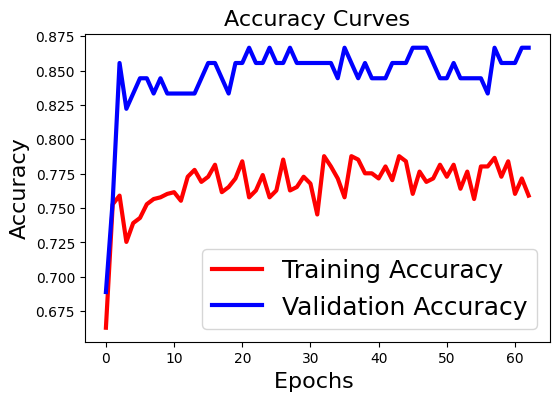

In [98]:
import matplotlib.pyplot as plt # visualizations

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(layer_1_unit, 
                          kernel_initializer = 'glorot_normal', 
                          bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(layer_2_unit, 
                          kernel_initializer = 'glorot_normal',
                          bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(layer_3_unit, 
                          kernel_initializer = 'glorot_normal',
                          bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, 
                          kernel_initializer = 'glorot_normal', 
                          bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'sigmoid')
])

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

import keras

# lr_sched = LearningRateScheduler(lambda epoch: 1e-2 * (0.75 ** np.floor(epoch / 2)))

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


# Create the learning rate scheduler
lr_sched = LearningRateScheduler(lambda epoch: 1e-3 * (0.75 ** np.floor(epoch / 2)))


# Compile the model with the optimizer and loss function
# adding lr_sched to keras.optimizers.Adam() will update learning rate every epoch
# adding lr_sched to model.fit() will update learning rate every batch
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(featurized_dataset, 
    labels, 
    epochs=epochs,
    batch_size=8, 
    validation_data=(validation_featurized_dataset, validation_labels), 
    callbacks=[early_stopping, lr_sched])

# history = model.fit(featurized_dataset, labels, epochs=epochs, validation_data=(validation_featurized_dataset, validation_labels))
valid_loss, valid_acc = model.evaluate(validation_featurized_dataset, validation_labels, verbose=2)
print('\nTest accuracy:', valid_acc)

plt.figure(figsize = [6, 4])
plt.plot(history.history['accuracy'], 'r', linewidth = 3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth = 3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 18)
plt.xlabel('Epochs ', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves', fontsize = 16)
plt.show()

In [99]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 16)                208       
                                                                 
 batch_normalization_21 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_126 (Dropout)       (None, 16)                0         
                                                                 
 dense_169 (Dense)           (None, 64)                1088      
                                                                 
 batch_normalization_22 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_127 (Dropout)       (None, 64)              

In [100]:
predictions = model.predict(validation_featurized_dataset)
output = pd.DataFrame({'PassengerId': validation_data.PassengerId.tolist(), 'Survived': predictions.tolist()})
predictions_zero_one = np.where(predictions > 0.5, 1, 0)
output = pd.DataFrame({'Label': validation_data.Survived.tolist(), 'Prediction': predictions_zero_one.reshape(-1).tolist()})
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(output['Prediction'], output['Label'])

acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
acc

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 0s 2ms/step


0.8666666666666667

In [101]:
test_predictions = model.predict(test_featurized_dataset)
test_predictions_zero_one = np.where(test_predictions > 0.5, 1, 0)
output = pd.DataFrame({'PassengerId': test_data.PassengerId.tolist(), 'Survived': test_predictions_zero_one.reshape(-1).tolist()})

output.to_csv('submission_tf.csv', index=False)
print("Your test predictions was successfully saved!")

14/14 [==============================] - 0s 929us/step
Your test predictions was successfully saved!
